In [1]:
import numpy as np
import pandas as pd
import apmodule as ap
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10 
plt.rcParams['lines.linewidth'] = 3
%matplotlib inline

## 1. Load the Data
As usual we start by loading **the returns** data and the data on **the signal** we want to test. We will also load data on **market capitalization**.

In [2]:
# we load the returns
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze()

# we load the market capitalization
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze()

# we load the information signal
gp = pd.read_csv('GP.zip', parse_dates=['date']).set_index(['id', 'date']).squeeze()

### 1.1 Focus on Large Caps
In our experiments so far we have used the entire universe of stocks available. When we analyze long-short equities this choice becomes risky because, as we know from the [_Seven Deadly Sins of Backtesting_](https://newyork.qwafafew.org/wp-content/uploads/sites/4/2015/10/Luo_20150128.pdf) it is easy to **grossly overestimate the performance** of a long-short strategy by assuming that we can borrow (and thus short-sell) every stock. In reality this is not the case, and the ability to short-sell is normally confined to **large and medium caps**.

To increase the validity of our next experiment we will limit our investment universe to a subsample of large companies.  To achieve this we will simply **rank all our shares** (in every month) by market capitalization and **keep only the largest 1500**.

This is a bit more generous than the standard [Russel 1000 Index](https://en.wikipedia.org/wiki/Russell_1000_Index) comprising the 1000 largest stocks in the US. 

In [3]:
# we join the information signal and the market capitalization
db = gp.to_frame().join(market_cap)

# we rank the sample (grouped by date)
db['rank'] = db.groupby('date')['market_cap'].rank(ascending=False, method='min')

# we select the stocks where the ranking is smaller than (or equal to) 1500
db = db[db['rank']<=1500]

We can then recover our information signal in a Series called `factor`

In [4]:
factor = db['gp']
factor

id     date      
10006  1980-01-31   -0.615467
       1980-02-29   -0.499435
       1980-03-31   -0.480637
       1980-04-30   -0.499327
       1980-05-30   -0.484212
                       ...   
93436  2022-08-31    0.307246
       2022-09-30    0.302742
       2022-10-31    0.426587
       2022-11-30    0.435297
       2022-12-30    0.436543
Name: gp, Length: 774000, dtype: float64

___
## 2. Market Neutral Strategy
Let's start by building a market neutral strategy where we take a long position in the top stocks and short sell the bottom stocks by the same amount (dollar neutrality). We will follow closely what we did for our long-only backtesing and will focus our attention on a simple ranking strategy where:
1. At the beginning of the period we rank all the shares on the information signal
1. We buy the N shares at the top of the ranking
1. We sell short the N shares at the bottom of the ranking

We can build this strategy as **a simple extension** of what we did in Notebook 9 for the long-only strategy (please refer back to that lecture if you need to refresh your memory). There we would rank the stocks in descending order and create a "Buy Signal" if the stock was among the top `N` in the ranking.

In [5]:
N=200
rank = factor.groupby('date').rank(ascending=False, method='min')
signal_long = (rank <= N).astype(int)
signal_long.head()

id     date      
10006  1980-01-31    0
       1980-02-29    0
       1980-03-31    0
       1980-04-30    0
       1980-05-30    0
Name: gp, dtype: int64

Here we simply add a second signal to identify the stocks to sell by **repeating the ranking in ascending order** this time:

In [6]:
rank = factor.groupby('date').rank(ascending=True, method='min')
signal_short = (rank <= N).astype(int)
signal_short.head()

id     date      
10006  1980-01-31    0
       1980-02-29    0
       1980-03-31    0
       1980-04-30    0
       1980-05-30    0
Name: gp, dtype: int64

We can finally build a global signal where long positions are indicated as `1` and short positions as `-1`.

In [7]:
signal = signal_long - signal_short
signal.groupby('date').value_counts()

date        gp
1980-01-31   0    1100
            -1     200
             1     200
1980-02-29   0    1100
            -1     200
                  ... 
2022-11-30  -1     200
             1     200
2022-12-30   0    1100
            -1     200
             1     200
Name: gp, Length: 1548, dtype: int64

From this point on the strategy works exactly as the long-only version: we will **build the Position by combining the buy/sell signal with the market capitalization** of the stocks. The final function would look something like this:

In [8]:
def mn_strategy(factor_data, market_cap, N=100):
    
    #We build the long signal
    rank = factor_data.groupby('date').rank(ascending=False, method='min')
    signal_long = rank <= N
    signal_long = signal_long.astype(int)
    
    #We build the short signal
    rank = factor_data.groupby('date').rank(ascending=True, method='min')
    signal_short = rank <= N
    signal_short = signal_short.astype(int)
    
    #We build the final signal
    signal = signal_long - signal_short
    
    #We join signal and market cap
    df = signal.rename('signal').to_frame().join(market_cap)
    
    #We calculate the position
    position = df['market_cap'] / df.groupby(['date', 'signal'])['market_cap'].transform('sum')
    position = position * df['signal']
    position = position.rename('position')
    
    return position

### 2.1 Backtesting of a Market Neutral Strategy
As in our long-only workflow, we will not use this function directly, it has been encapsulated in a market-neutral backtesting function `mn_backtesting()` designed on the same principles as the long-only version:

The MN backtesting function requires eight inputs and produces four different output. The input parameters are:
1. The information **signal** (passed as a series)
1. The stock **prices** (passed as a series)
1. The market **capitalization** (passed as a series)
1. The **Start** Date (this can be omitted)
1. The **End** Date (this can also be omitted)
1. The rebalancing **frequency** (the default value is rebalancing every month)
1. The round-trip **transaction costs** (the default value is zero)
1. The **number of stocks** we want to buy/short-sell (works similarly to the `N` parameter in our ranking strategy, the default value is 100)

The output produced are (in this precise order):
1. A DataFrame with the monthly **return** of the portfolio
1. A DataFrame with the monthly **turnover** and transaction costs of the strategy
1. A DataFrame with the **composition** of the portfolio
1. A DataFrame with a number of **performance metrics** for the portfolio

Before we discuss this in more detail let's take it out for a spin:

In [9]:
mn_ret, mn_turn, mn_comp, mn_perf = ap.mn_backtesting(factor, prices, market_cap, 
                                                      start='1990-01-01', end='2007-12-31', 
                                                      frequency=3, t_cost=0.0015, N=200)

All the output objects have the same structure as before. Let's **look at the performance** of our market Neutral Strategy

In [10]:
mn_perf

,MN Portfolio
Mean Return,0.045275
St. Dev.,0.111933
RR Ratio,0.404487
% Positive,0.537037
Worst Month,-0.090330
Best Month,0.098531
Max DrawDown,-0.314310


We can plot it as usual

<Axes: title={'center': 'Market Neutral Strategy'}, xlabel='Time', ylabel='Portfolio Value'>

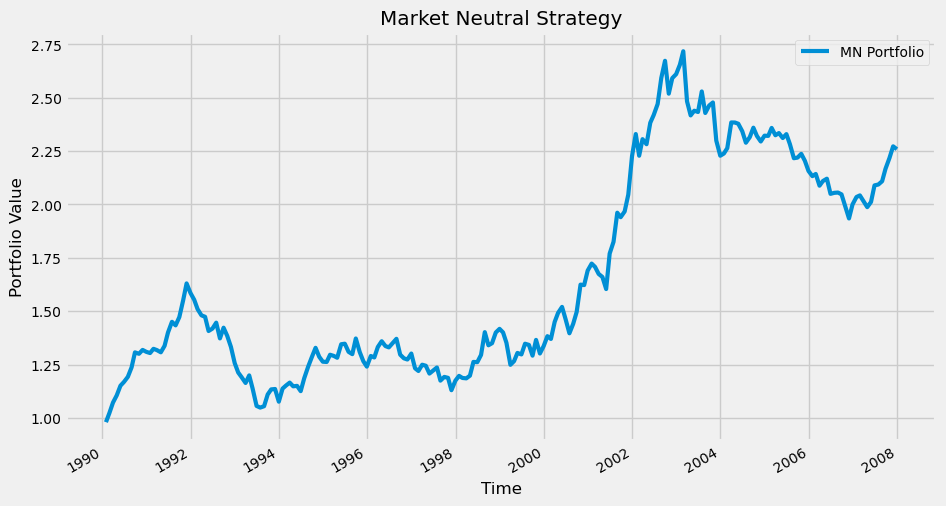

In [11]:
port_values = mn_ret.cumsum().apply(np.exp)

port_values.plot(figsize=(10,6),
                 title='Market Neutral Strategy',
                 ylabel='Portfolio Value',
                 xlabel='Time')

Let's compare the return of this market neutral strategy with the return of the long-only version:

In [12]:
p_ret, p_turn, p_comp, p_perf = ap.backtesting(factor, prices, market_cap, 
                                               start='1990-01-01', end='2007-12-31', 
                                               frequency=3, t_cost=0.0015, N=200)

p_perf

,Portfolio,Benchmark,Active
Mean Return,0.092251,0.052976,0.039276
St. Dev.,0.149468,0.144592,0.076864
RR Ratio,0.617197,0.366381,0.510973
% Positive,0.560185,0.611111,0.550926
Worst Month,-0.169246,-0.161799,-0.061207
Best Month,0.142098,0.104115,0.067152
Max DrawDown,-0.357166,-0.469302,-0.154026


The average monthly return of the market neutral strategy is **significantly lower** than the long-only version, but **this is normal**. Remember that the market neutral portfolio has zero net investment, so it is more closely related to the Active return of the long-only strategy where we go long in the top `N` stocks and short on the market.

<Axes: title={'center': 'Zero-Investment Portfolios'}, xlabel='Time', ylabel='Portfolio Value'>

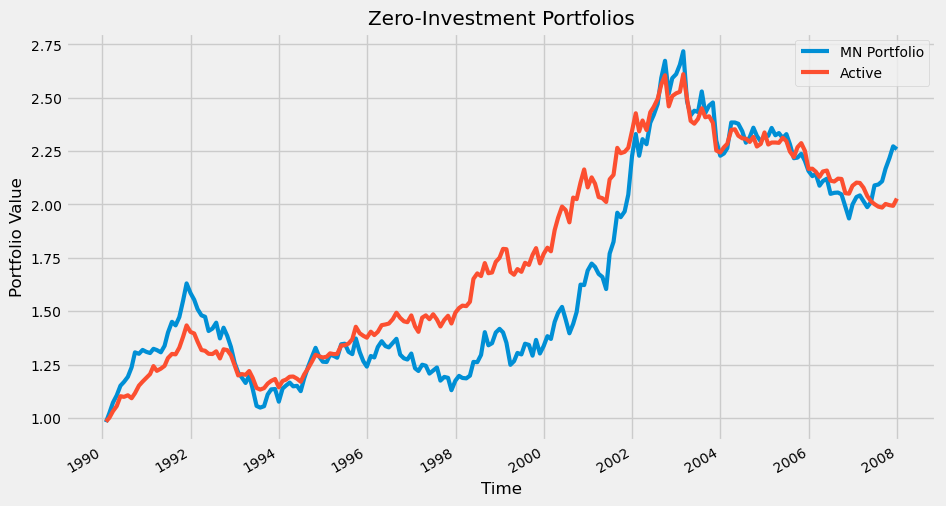

In [13]:
#We join the monthly return of the MN strategy with the active return of the long-only strategy
combined = mn_ret.join(p_ret['Active'])

#We can now plot them together
port_values = combined.cumsum().apply(np.exp)

port_values.plot(figsize=(10,6),
                 title='Zero-Investment Portfolios',
                 ylabel='Portfolio Value',
                 xlabel='Time')

As you can see, going long on the top stocks and short on the market yields roughly the same performance as going long on the top stocks and short on the "bad" stocks. This means that our factors is not particularly good at identifying "bad companies".
___
## 3. 130/30 Long-Short Strategy
Market Neutral strategies are **not common among retail investment products**. This is partly due to legal constraints to the use of leverage and short-selling, and partly to the difficulty to market them.

130/30 portfolios are a more practical approach to long-short investment where we build a long-only portfolio that replicates the market and then add a **small under-investment** in a group of _bad stocks_ and an **equally sized over-investment** in a group of _good stocks_.

From the practical point of view the construction of the strategy is trivial.
1. Use a double **ranking process** to identify the top and bottom N stocks.
1. Build a long only portfolio with the **market weights**
1. Build the **active weight**: positive for the top stocks and negative for the bottom stocks.
1. Calculate the **portfolio weights** as the sum of market and active weight

In [14]:
def ls_strategy(factor_data, market_cap, N=100, active=0.3):
    
    #We build the long signal
    rank = factor_data.groupby('date').rank(ascending=False, method='min')
    signal_long = (rank <= N).astype(int)
    
    #We build the short signal
    rank = factor_data.groupby('date').rank(ascending=True, method='min')
    signal_short = (rank <= N).astype(int)
    
    #We build the final signal
    signal = signal_long - signal_short
    
    #We join signal and market cap
    df = signal.rename('signal').to_frame().join(market_cap)
    
    #We calculate the weight of the stocks in the market
    market_weight = df['market_cap'] / df.groupby('date')['market_cap'].transform('sum')
    
    #We calculate the active weight in the top/bottom N stocks
    active_weight = df['signal'] * active / N
    
    #We calculate the position as the sum of market and active weight
    position = market_weight + active_weight
    position = position.rename('position')
    
    #We calculate the benchmark as the market weighted portfolio with all the shares
    benchmark = df['market_cap'] / df.groupby('date')['market_cap'].transform('sum')
    benchmark = benchmark.rename('benchmark')
    
    #We return the two series
    return position, benchmark

### 3.1 Backtesting of a 130/30 portfolio
As usual this function is integrated in the appropriate backtesting function `ls_backtesting()`

In [15]:
ls_ret, ls_turn, ls_comp, ls_perf = ap.ls_backtesting(factor, prices, market_cap, 
                                                      start='1990-01-01', end='2007-12-31', 
                                                      frequency=3, t_cost=0.0015, N=200, active=0.3)

ls_perf

,LS Portfolio,Benchmark,LS Active
Mean Return,0.084125,0.052976,0.031149
St. Dev.,0.142989,0.144592,0.037534
RR Ratio,0.588329,0.366381,0.829881
% Positive,0.587963,0.611111,0.560185
Worst Month,-0.170773,-0.161799,-0.020695
Best Month,0.118827,0.104115,0.057414
Max DrawDown,-0.304320,-0.469302,-0.050824


Since the 130/30 strategy creates a **fully-invested portfolio** (sum of the weights equal to 100%) we can compare it with the long-only portfolio to see **if the 30/30 portfolio adds any value**. To eliminate the common effect of general market movement let's focus on the active return of the two strategies.

Rather than look at two different tables we can combine the diagnostics in a single DataFrame.

In [16]:
active_perf = p_perf['Active'].to_frame().join(ls_perf['LS Active'])
active_perf

,Active,LS Active
Mean Return,0.039276,0.031149
St. Dev.,0.076864,0.037534
RR Ratio,0.510973,0.829881
% Positive,0.550926,0.560185
Worst Month,-0.061207,-0.020695
Best Month,0.067152,0.057414
Max DrawDown,-0.154026,-0.050824


As we can see, while the long-only portfolio has a better mean active return than the 130/30 portfolio, the long-short portfolio has a lower tracking error and a much higher information ratio. 

### 3.2 Targeting a specific TE

We can **control the tracking error level** of our strategy with the `active` parameter in the function that regulates the active percentage of portfolio: a 110/10 strategy will have a lower TE than a 150/50.

To achieve a comparable level of TE we **will likely need to double** our active percentage (to 60%), effectively running a 160/60 strategy:

In [18]:
ls60_ret, ls60_turn, ls60_comp, ls60_perf = ap.ls_backtesting(factor, prices, market_cap, 
                                                              start='1990-01-01', end='2007-12-31', 
                                                              frequency=3, t_cost=0.0015, N=200, active=0.6)

active_perf = active_perf.join(ls60_perf['LS Active'].rename('LS Active 60%'))
active_perf

,Active,LS Active,LS Active 60%
Mean Return,0.039276,0.031149,0.060308
St. Dev.,0.076864,0.037534,0.073376
RR Ratio,0.510973,0.829881,0.821904
% Positive,0.550926,0.560185,0.569444
Worst Month,-0.061207,-0.020695,-0.041360
Best Month,0.067152,0.057414,0.105774
Max DrawDown,-0.154026,-0.050824,-0.103276


We can now see that the long-short strategy yields a **significantly higher active return with roughly the same tracking error**. To get a visual representation we can plot the total return of the two strategies:

<Axes: title={'center': 'Long-Only vs Long-Short'}, xlabel='Time', ylabel='Portfolio Value'>

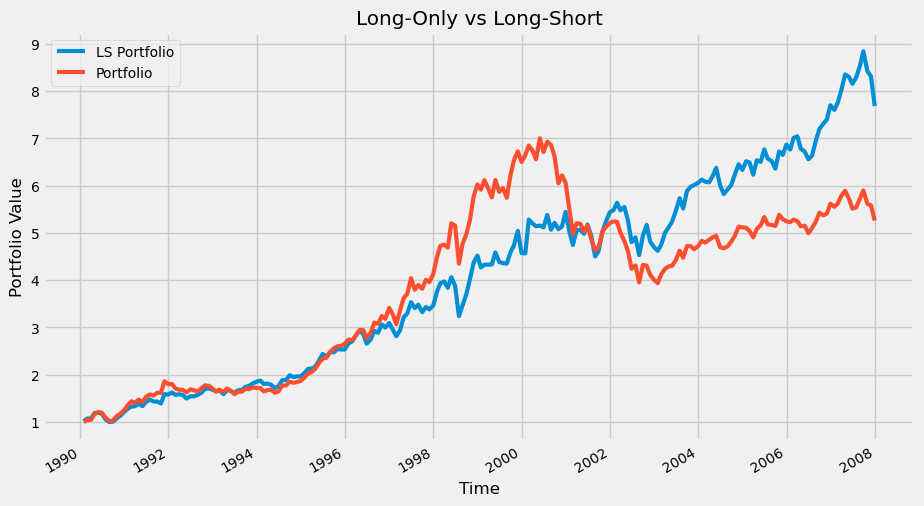

In [19]:
#We join the monthly return of the MN strategy with the active return of the long-only strategy
combined = ls60_ret['LS Portfolio'].to_frame().join(p_ret['Portfolio'])

#We can now plot them together
port_values = combined.cumsum().apply(np.exp)

port_values.plot(figsize=(10,6),
                 title='Long-Only vs Long-Short',
                 ylabel='Portfolio Value',
                 xlabel='Time')

___
## Exercise 11.01
The choice of a target TE level in a long-short strategy is often a marketing choice more than a finance one. Low TE strategies (normally called _Index Plus_) are marketed as passive portfolios with a small upside potential. Higher TE level are instead marketed as active bets on a specific information signal.

In this exercise you should examine the relationship between active percentage and tracking error:
* Build a for-loop to go through all the values in the list `active_levels`
* For each level backtest a 1XX/XX strategy
* From the performance output DataFrame extract the Tracking error and append it to the `tracking_errors` list

At the end of the loop
* Transform the list `tracking_errors` into a DataFrame using the function [**`pd.DataFrame()`**](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). In this DataFrame you should name the column `Tracking Errors` and pass the list `active_levels` as the index.
* Plot the relationship between active levels and tracking error

In [20]:
active_levels = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

tracking_errors = []

for level in active_levels:
    
    lx_ret, lx_turn, lx_comp, lx_perf = ap.ls_backtesting(factor, prices, market_cap, 
                                                      start='1990-01-01', end='2007-12-31', 
                                                      frequency=3, t_cost=0.0015, N=200, active=level)
    
    tracking_errors.append(lx_perf.loc['St. Dev.', 'LS Active'])
    
result = pd.DataFrame(tracking_errors, columns=['Tracking Errors'], index=active_levels)
result

,Tracking Errors
0.05,0.008184
0.10,0.013778
0.20,0.025584
0.30,0.037534
0.40,0.049498
0.50,0.061448


<Axes: title={'center': 'Active Percentage and Tracking Error'}, xlabel='Active Percentage', ylabel='Tracking Error'>

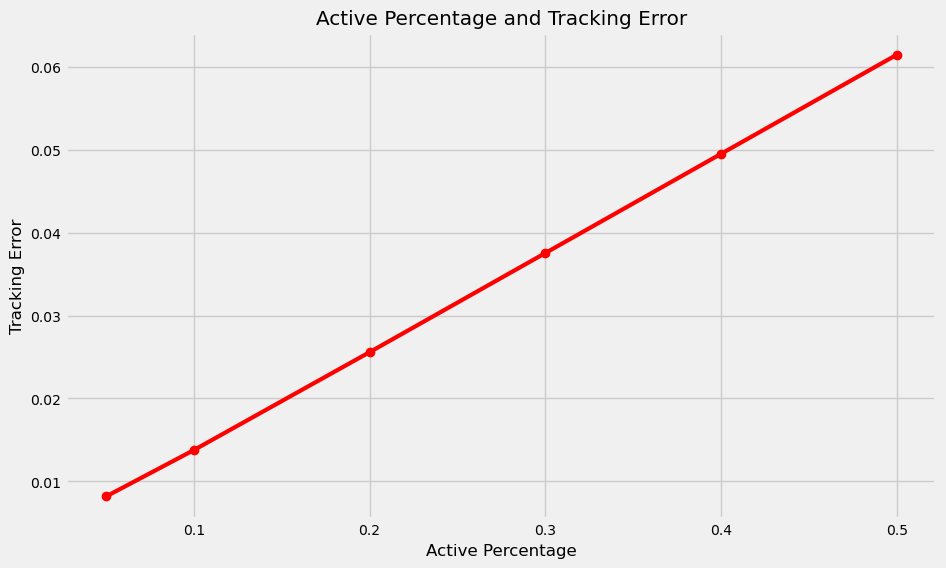

In [21]:
result.plot(style='r-o',
            title='Active Percentage and Tracking Error',
            ylabel='Tracking Error',
            xlabel='Active Percentage',
            legend=False,
            figsize=(10,6))

___
## Exercise 11.02
Most traditional investment factors tend to work better, on paper, with smaller stocks. 

Copy and modify the appropriate lines from the data section in order to recreate an alternative version of the DataFrame `db` and the series `factor` **where we only focus on the largest 500 companies** (roughly the S&P 500 Index). Backtest a 130/30 strategy on this sample (with `N=100`) and observe its performance. Is it still worth running this strategy?

In [22]:
# we join the information signal and the market capitalization
db500 = gp.to_frame().join(market_cap)
db500['rank'] = db500.groupby('date')['market_cap'].rank(ascending=False, method='min')
db500 = db500[db500['rank']<=500]

factor500 = db500['gp']

ls_ret, ls_turn, ls_comp, ls_perf = ap.ls_backtesting(factor500, prices, market_cap, 
                                                      start='1990-01-01', end='2007-12-31', 
                                                      frequency=3, t_cost=0.0015, N=100, active=0.3)

ls_perf

,LS Portfolio,Benchmark,LS Active
Mean Return,0.073017,0.059394,0.013623
St. Dev.,0.141376,0.142007,0.029480
RR Ratio,0.516473,0.418251,0.462102
% Positive,0.578704,0.611111,0.550926
Worst Month,-0.152953,-0.151012,-0.021865
Best Month,0.119321,0.105935,0.025526
Max DrawDown,-0.397073,-0.466804,-0.068082


You should notice a sharp reduction in the Information Ratio of the Strategy. If we focus on the largest stocks, our strategy looses much of its power.

If you want a counter-example **repeat the exercise focusing on the 3000 largest stocks** (basically we imagine to be able to trade both large and small caps), you can try `N=500`.

In [23]:
db3000 = gp.to_frame().join(market_cap)
db3000['rank'] = db3000.groupby('date')['market_cap'].rank(ascending=False, method='min')
db3000 = db3000[db3000['rank']<=3000]

factor3000 = db3000['gp']

ls_ret, ls_turn, ls_comp, ls_perf = ap.ls_backtesting(factor3000, prices, market_cap, 
                                                      start='1990-01-01', end='2007-12-31', 
                                                      frequency=3, t_cost=0.0015, N=500, active=0.3)

ls_perf

,LS Portfolio,Benchmark,LS Active
Mean Return,0.098518,0.049091,0.049427
St. Dev.,0.142805,0.145859,0.038476
RR Ratio,0.689879,0.336568,1.284622
% Positive,0.606481,0.601852,0.680556
Worst Month,-0.166787,-0.165725,-0.024191
Best Month,0.117515,0.102682,0.069501
Max DrawDown,-0.279602,-0.471678,-0.042884


And you should observe a **sharp increase in the Information Ratio**. 

Now it should be clear why so many backtests lead to excessively optimistic result: much of the power is focused on small caps where **forecasting transaction costs is so much more difficult**. 